# Face Detection Demo

In [1]:
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import random
import ipyplot

from utils import *

load_dotenv()
Migrator().run()

## Update/Refresh RedisDB 
Updates your redis DB with filenames found in the `CONTAINER_IMAGE_FOLDER`

In [2]:
query = CONTAINER_IMAGE_FOLDER.split("/")[1]
delete = Model.find(Model.filename % query).all()
for r in tqdm(delete, desc="Deleting existing keys"):
    try:
        Model.delete(r.pk)
    except Exception as e:
        print("There was an exception with {}\n{}".format(r, e))

filenames = index_directory(CONTAINER_IMAGE_FOLDER, formats=(".png", ".jpeg", ".jpg"))

for filename in tqdm(filenames, desc="Writing filenames to redis db."):
    try:
        Model(filename=filename, size=0).save()
    except Exception as e:
        print("There was an exception with {}\n{}".format(filename, e))

models = Model.find(Model.filename % query).all()

Deleting existing keys:   0%|          | 0/7 [00:00<?, ?it/s]

Indexed 6 file(s) in 0.057 seconds.


Writing filenames to redis db.:   0%|          | 0/6 [00:00<?, ?it/s]

## Face Detect on Triton
Get Face Detect's information from Triton Server

In [3]:
triton_client = grpcclient.InferenceServerClient(url=TRITON_SERVER_URL, verbose=False)

model_metadata = triton_client.get_model_metadata(
    model_name=FACE_DETECT_MODEL_NAME, model_version=MODEL_VERSION
)

model_config = triton_client.get_model_config(
    model_name=FACE_DETECT_MODEL_NAME, model_version=MODEL_VERSION
).config

input_names = [i.name for i in model_config.input]
output_names = [i.name for i in model_config.output]
print("expected input names:{}".format(input_names))

print("expected output names:{}".format(output_names))

expected input names:['input_image_data']
expected output names:['true_boxes', 'true_proba', 'true_image_size']


## Run Inference
Submit images found in `CONTAINER_IMAGE_FOLDER` to Triton Server and write to RedisDB.

In [4]:
pbar = tqdm(
    total=len(models),
    desc="Submitting photos to {} at {}".format(
        FACE_DETECT_MODEL_NAME, TRITON_SERVER_URL
    ),
)

results = []

with ThreadPoolExecutor() as executor:
    for chunk in chunked(models, THREAD_CHUNKS):
        futures = []
        for model in chunk:
            futures.append(
                executor.submit(
                    submit_to_facedetect,
                    model.filename,
                    input_names,
                    output_names,
                    model.pk,
                )
            )

        for future in as_completed(futures):
            pbar.update()
            try:
                infer_result = future.result()
                model = Model.get(infer_result.get_response().id)
                image_wise_bboxes = infer_result.as_numpy(output_names[0]).reshape(
                    -1, 4
                )
                image_probas = infer_result.as_numpy(output_names[1]).reshape(-1, 1)

                h, w, c = infer_result.as_numpy(output_names[2]).squeeze()
                model.channels = int(c)
                model.height = int(h)
                model.width = int(w)
                model.portrait = int(h > w)

                for bbox, proba in zip(image_wise_bboxes, image_probas):
                    model.faces = [
                        {
                            "bbox": {
                                "x1": int(round(bbox[0], 0)),
                                "y1": int(round(bbox[1], 0)),
                                "x2": int(round(bbox[2], 0)),
                                "y2": int(round(bbox[3], 0)),
                            },
                            "probability": int(round(proba[0], 0)),
                        }
                        for bbox, proba in zip(image_wise_bboxes, image_probas)
                    ]
                model.save()

            except Exception as e:
                print("There was an exception: {}.".format(e))

Submitting photos to facenet_ensemble at 172.25.4.42:8001:   0%|          | 0/6 [00:00<?, ?it/s]

There was an exception: [StatusCode.UNKNOWN] in ensemble 'facenet_ensemble', Runtime error: Critical error in pipeline:
Error when executing CPU operator PeekImageShape encountered:
Error in thread 8: [/opt/dali/dali/image/image_factory.cc:102] Unrecognized image format. Supported formats are: JPEG, PNG, BMP, TIFF, PNM, JPEG2000 and WebP.
Stacktrace (7 entries):
[frame 0]: /opt/tritonserver/backends/dali/dali/libdali.so(+0x847ff) [0x7f1b4aac67ff]
[frame 1]: /opt/tritonserver/backends/dali/dali/libdali.so(dali::ImageFactory::CreateImage(unsigned char const*, unsigned long, dali::DALIImageType)+0x204) [0x7f1b4abcdfe4]
[frame 2]: /opt/tritonserver/backends/dali/dali/libdali_operators.so(+0x21ba36d) [0x7f19cd49036d]
[frame 3]: /opt/tritonserver/backends/dali/dali/libdali.so(dali::ThreadPool::ThreadMain(int, int, bool, std::string const&)+0x1d0) [0x7f1b4aba4700]
[frame 4]: /opt/tritonserver/backends/dali/dali/libdali.so(+0x7408bf) [0x7f1b4b1828bf]
[frame 5]: /usr/lib/x86_64-linux-gnu/libpth

## Display example output

Looks like /workspace/sample-imgs/next_generation/sample_3.jpg has 7 faces.

{'pk': '01GK7M20WW0BBZF7G9KA7DF3GM', 'filename': '/workspace/sample-imgs/next_generation/sample_3.jpg', 'faces': [{'pk': '01GK7M212J34NYEVP69A82DZS6', 'bbox': {'pk': '01GK7M212JNN79ZDBAXY48Y3TD', 'x1': 92, 'y1': 89, 'x2': 170, 'y2': 200}, 'probability': 7, 'label': None, 'rotation': None, 'descriptors': None}, {'pk': '01GK7M212JH2RQBP4QDD05DYP5', 'bbox': {'pk': '01GK7M212J6S4231MAVWZGRNQK', 'x1': 287, 'y1': 232, 'x2': 366, 'y2': 341}, 'probability': 8, 'label': None, 'rotation': None, 'descriptors': None}, {'pk': '01GK7M212JK9GD92N61V7ZA3CH', 'bbox': {'pk': '01GK7M212JHQWATH26DP4BETBV', 'x1': 364, 'y1': 28, 'x2': 441, 'y2': 140}, 'probability': 7, 'label': None, 'rotation': None, 'descriptors': None}, {'pk': '01GK7M212J88WRC3YH0N5BTF6D', 'bbox': {'pk': '01GK7M212JZV0WG252F83N911V', 'x1': 458, 'y1': 315, 'x2': 555, 'y2': 458}, 'probability': 10, 'label': None, 'rotation': None, 'descriptors': None}, {'pk': '01G

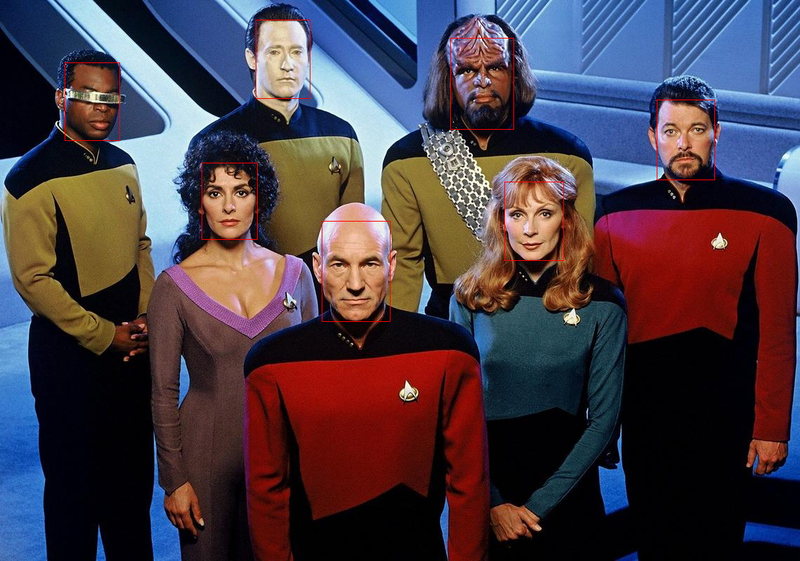

In [5]:
# Re-query since it's all been updated.
models = Model.find(Model.filename % query).all()

for model in models:
    try:
        if len(model.faces) > 0:
            print(
                "Looks like {} has {} faces.\n".format(model.filename, len(model.faces))
            )
            break
        else:
            continue
    except:
        pass
print(model.dict())

render_image(model, output_size=800)

___